In [7]:
#%matplotlib notebook
import sys
import os
#messi
# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

import s2p
import pickle
import rpcm
import glob
import json
import copy
import rpc_fit
import timeit

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Experiment name 

In [2]:
exp_name = 'skysat_L1A/dona_juana2_9'
input_dir = os.path.join('exp/',exp_name)

### Read SkySat images and RPCs

In [3]:
# read tiff images 
myimages = np.sort(glob.glob(input_dir+'/frames/*.tif'))
#myimages = myimages[:3]
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
myimg = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    myimg.append(utils.simple_equalization_8bit(tmp))
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })

# load RPC coefficients
myrpcs = [rpcm.rpc_from_rpc_file(os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
#myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# update myimages list
pickle_out = open(input_dir+'/myimages.pickle','wb')
pickle.dump([os.path.basename(imagefn) for imagefn in myimages], pickle_out)
pickle_out.close()

Found 9 images
Number of images to be used: 9
Finished loading RPC coefficients


### RPCs from projection matrices

In [4]:
#if not os.path.isdir(input_dir+'/rpc_from_P'):
#    os.mkdir(input_dir+'/rpc_from_P')

# rpc fitting starts here
verbose = True
for im_idx in range(len(myrpcs)):

    rpc_init = copy.copy(myrpcs[im_idx])
    h, w = mycrops[im_idx]['crop'].shape
    
    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
        input_P = np.array(json.load(f)['P_projective'])
    
    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)

    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 500, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    # warning: this is slow...
    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts, samples = p[idx_to_preserve], samples[idx_to_preserve]

    #fig = plt.figure(figsize=(20,6))
    #plt.imshow((mycrops[im_idx]['crop']), cmap="gray")
    #for k in range(proj_pts.shape[0]):
    #    plt.plot(*proj_pts[k][::-1], 'rx') 
    #plt.show()
    
    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)
    print('image {}, RMSE calibrated RPC = {}'.format(im_idx, err_calib))
    
    #rpc_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_rpc_adj.txt'
    #rpc_calib.write_to_file(input_dir+'/rpc_from_P/'+rpc_calib_fn)
    
    # check the histogram of errors if the RMSE error is above subpixel
    if err_calib > 1.0 and verbose:
        col_pred, row_pred = rpc_calib.projection(lon, lat, alt)
        err = np.sum(abs(np.hstack([col_pred.reshape(-1, 1), row_pred.reshape(-1, 1)]) - target), axis=1)
        plt.figure()
        plt.hist(err, bins=30);
        plt.show()

    myrpcs[im_idx] = copy.copy(rpc_calib)

image 0, RMSE calibrated RPC = 0.00021362534745121838
image 1, RMSE calibrated RPC = 0.00019487129182668933
image 2, RMSE calibrated RPC = 0.000233043801462547
image 3, RMSE calibrated RPC = 0.00014784612430271415
image 4, RMSE calibrated RPC = 0.00010054917810354038
image 5, RMSE calibrated RPC = 9.891166203417454e-05
image 6, RMSE calibrated RPC = 0.00017304405804614815
image 7, RMSE calibrated RPC = 0.0001943414368228454
image 8, RMSE calibrated RPC = 0.00016171454392056468


### Read projection matrices

In [5]:
cam_model = 'Perspective'
P_crop = []
for iter_cont in np.arange(len(mycrops)):
    with open(os.path.splitext(myimages[iter_cont])[0]+'_pinhole.json', 'r') as f:
        P_img = np.array(json.load(f)['P_projective'])
    P_crop.append(P_img/P_img[2,3])
    print('\rCamera {} / {} done'.format(iter_cont+1, len(mycrops)), end = '\r')
print('\nProjection matrices read')

Camera 9 / 9 done
Projection matrices read


### Feature Track Detection 1.0

Improvements w.r.t version 0.0: hashing and intersection to build the tracks quickly as the new pairwise matches are found (sequential process).

In [ ]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2

#FEATURE TRACKS REPRESENTATION
#feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
#r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'

input_seq = [mycrops[f]['crop'] for f in range(len(mycrops))]   
input_P = P_crop

print('Running feature detection...\n')
start = timeit.default_timer()
last_stop = start

# (1) detect SIFT keypoints in all images
reduce_kp, max_kp_per_im = False, 7000
n_img = len(input_seq)

kp_cont = 0
features = []
for idx in range(n_img):
    kp, des = ba_utils.find_SIFT_kp(input_seq[idx])
    if kp.shape[0] > max_kp_per_im and reduce_kp:
        prev_idx = np.arange(kp.shape[0])
        new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
        new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
        kp, des = new_kp, new_des
    features.append({ 'kp': kp, 'des': des, 'id': np.arange(kp_cont, kp_cont + len(kp)).tolist() })
    print('Found', kp.shape[0], 'keypoints in image', idx)
    kp_cont += kp.shape[0]
    #im_kp=cv2.drawKeypoints(input_seq[idx],kp,outImage=np.array([]))
    #vistools.display_image(im_kp) 

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

print('\nComputing pairs to be matched...\n')

#(2) pairs with extremly short baselines are not well posed for depth from stereo so we filter them
pairs_to_match, matching_args = [], []
for i in range(n_img):
    for j in range(i+1,n_img):
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(input_P[i])
        _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(input_P[j])

        baseline_thr = 150000 # esto deberian ser un poco más de la distancia recorrida en medio segundo (en m ?)
                              # no me cuadra mucho con la supuesta speed de skysat de 7 km/s (~3500 m en medio s)

        if np.linalg.norm(optical_center2 - optical_center1) > baseline_thr :
            pairs_to_match.append([i,j])
            kp_i, des_i, kp_i_id = features[i]['kp'], features[i]['des'], np.array(features[i]['id'])
            kp_j, des_j, kp_j_id = features[j]['kp'], features[j]['des'], np.array(features[j]['id'])
            matching_args.append((kp_i, kp_j, des_i, des_j))

print('{} / {} pairs to be matched'.format(len(pairs_to_match),int((n_img*(n_img-1))/2)))          

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

print('\nMatching...\n')

# (3) create feature tracks
tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
for [i,j] in pairs_to_match:
    kp_i, des_i = features[i]['kp'], features[i]['des']
    kp_j, des_j = features[j]['kp'], features[j]['des']
    pts_i, pts_j, kp_i, kp_j, m_filt, m_all, _, _ = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
    n_matches = 0 if pts_i is None else pts_i.shape[0]
    print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))

    # display matches for pair (i,j)
    #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
    #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

    if pts_i is not None:
        pts_i_tuples = [tuple(pair) for pair in pts_i.tolist()]
        pts_i_dict = {pair:i for i, pair in enumerate(pts_i_tuples)}

        pts_i_track = [tuple(pair) for pair in feature_tracks[:,:,i].tolist()]
        pts_i_track_dict = {pair:i for i, pair in enumerate(pts_i_track)}

        intersect = np.array([[pts_i_dict[k], pts_i_track_dict[k]] for k in pts_i_dict.keys()&pts_i_track_dict.keys()])
        # attention: the meaning/interst of 'intersect' is not trivial
        # each value in 'idx_pts_i' is the index of an observation X from 'pts_i', while each corresponding
        # value in 'idx_existing_tracks' is the index of the track that contains the observation X 
        if intersect.shape[0] > 0:
            idx_pts_i, idx_existing_tracks = intersect[:,0], intersect[:,1]
            # extend existing tracks by adding the coords of observation X in image j from pts_j
            feature_tracks[idx_existing_tracks,:,j] = pts_j[idx_pts_i,:]
            r[idx_existing_tracks,i], r[idx_existing_tracks,j] = 1, 1

        # list of points in 'pts_i' that do not correspond to any previous feature track
        new_pts_from_i = list(set(pts_i_dict) - set(pts_i_track_dict))
        if len(new_pts_from_i) > 0:
            new_pts_from_j = [tuple(pts_j[pts_i_dict[k],:]) for k in new_pts_from_i]
            new_tracks = np.zeros((len(new_pts_from_i),2,n_cam))
            new_tracks[:,:,i], new_tracks[:,:,j]  = np.array(new_pts_from_i), np.array(new_pts_from_j)
            new_r = np.zeros((len(new_pts_from_i),n_cam))
            new_r[:,i], new_r[:,j] = 1, 1
            feature_tracks, r = np.vstack((feature_tracks, new_tracks)), np.vstack((r, new_r))

feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]

stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

print('\nBuilding correspondence matrix C...\n')

C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)

stop = timeit.default_timer()
print('\n\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

hours, rem = divmod(last_stop - start, 3600)
minutes, seconds = divmod(rem, 60)
print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))

pickle_out = open(input_dir+'/features.pickle','wb')
pickle.dump(C, pickle_out)
pickle_out.close()
print('\nCorrespondence matrix saved!')

### Feature Track Detection 2.0

Improvements w.r.t version 1.0: uses the union-find algorithm (i.e. the construction of feature tracks is not sequential anymore).

In [17]:
input_seq = [mycrops[f]['crop'] for f in range(len(mycrops))]    
input_P = P_crop
input_rpcs = myrpcs
n_img = len(input_seq)

start = timeit.default_timer()
last_stop = start

# (0) get pairs to match and triangulate
print('\nComputing pairs to match...\n')
footprints = ba_utils.get_image_footprints(myrpcs, input_seq)
im_ind = np.arange(n_img)
all_pairs = [(im_i, im_j) for im_i in im_ind for im_j in im_ind if im_i != im_j and im_i<im_j]
pairs_to_match, pairs_to_triangulate = ba_utils.filter_pairs_to_match_skysat(all_pairs, footprints, P_crop)
stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop 

# (1) feature detection
print('\nRunning feature detection...\n')
features = ba_utils.feature_detection_skysat(input_seq, input_rpcs, footprints)
pickle_out = open(input_dir+'/features.pickle','wb')
pickle.dump(features, pickle_out)
pickle_out.close()
print('\nDetected features saved!')
stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop


# (2) matching
print('\nMatching...\n')
pairwise_matches = ba_utils.matching_skysat(pairs_to_match, features)    
pickle_out = open(input_dir+'/matches.pickle','wb')
pickle.dump([pairwise_matches, pairs_to_match, pairs_to_triangulate], pickle_out)
pickle_out.close()
print('\nPairwise matches saved!')      
stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

# (3) extend pairwise matches to feature tracks
print('\nBuilding feature tracks...\n')
C = ba_utils.feature_tracks_from_pairwise_matches(features, pairwise_matches, pairs_to_triangulate)
pickle_out = open(input_dir+'/Cmatrix.pickle','wb')
pickle.dump(C, pickle_out)
pickle_out.close()
print('\nCorrespondence matrix saved!')
stop = timeit.default_timer()
print('\n...done in {} seconds'.format(stop - last_stop))
last_stop = stop

hours, rem = divmod(last_stop - start, 3600)
minutes, seconds = divmod(rem, 60)
print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))


Computing pairs to match...

23 / 36 pairs to be matched

...done in 2.976678377017379 seconds

Running feature detection...

Found 14938 keypoints in image 0
Found 14882 keypoints in image 1
Found 15805 keypoints in image 2
Found 14944 keypoints in image 3
Found 14134 keypoints in image 4
Found 14629 keypoints in image 5
Found 13990 keypoints in image 6
Found 14100 keypoints in image 7
Found 14513 keypoints in image 8

Detected features saved!

...done in 8.736950550228357 seconds

Matching...

Pair (0,1) -> 1405 matches
Pair (0,3) -> 307 matches
Pair (0,4) -> 43 matches
Pair (0,6) -> 55 matches
Pair (0,7) -> 7 matches
Pair (1,2) -> 1486 matches
Pair (1,3) -> 81 matches
Pair (1,4) -> 271 matches
Pair (1,5) -> 46 matches
Pair (1,6) -> 0 matches
Pair (1,7) -> 18 matches
Pair (1,8) -> 7 matches
Pair (2,5) -> 210 matches
Pair (2,8) -> 18 matches
Pair (3,4) -> 2063 matches
Pair (3,6) -> 308 matches
Pair (3,7) -> 166 matches
Pair (4,6) -> 117 matches
Pair (4,7) -> 295 matches
Pair (4,8) ->

### Feature Track Detection 3.0

Uses union-find + parallelized s2p matching + intersection over image footprints to futher discard useless matching pairs.

In [16]:
if feature_tracks_3:

    from numpy.core.defchararray import add as add_str

    def create_kp_id(pt_coords, im_idx):
        pt = np.around(pt_coords[:,:2],4)
        pt_str = add_str(add_str('(',add_str(pt[:,0].astype('str'),',')),add_str(pt[:,1].astype('str'),')'))
        kp_id = add_str(pt_str,add_str('-',str(im_idx)))
        return kp_id

    import timeit
    from multiprocessing import Pool

    thresh_dog = 0.0133
    nb_octaves = 8
    nb_scales = 3
    offset = None

    n_img = len(mycrops)
    sift_args = [(mycrops[f]['crop'], thresh_dog, nb_octaves, nb_scales, offset) for f in range(n_img)]    

    print('Running feature detection...\n')
    start = timeit.default_timer()
    last_stop = start

    # (1) detect SIFT keypoints in all images

    with Pool() as p:
        features_output = p.starmap(s2p.sift.keypoints_from_nparray, sift_args)

    kp_cont = 0
    reduce_kp, max_kp_per_im = False, 7000
    features, kp_id_to_kp_idx, all_vertices, all_keypoints = [], {}, [], []
    for idx in range(n_img):
        kp = features_output[idx]
        if kp.shape[0] > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(kp.shape[0])
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            kp = kp[new_idx, :]
        all_keypoints.extend(kp[:,:2].tolist())
        kp_id = create_kp_id(kp[:,:2], idx)
        kp_idx = np.arange(kp_cont, kp_cont + kp.shape[0]).tolist()
        kp_id_to_kp_idx.update(dict(zip(kp_id, kp_idx)))
        tmp = np.vstack((np.ones(kp.shape[0]).astype(int)*idx, kp_idx)).T
        all_vertices.extend( tmp.tolist() )
        print('Found', kp.shape[0], 'keypoints in image', idx)
        kp_cont += len(kp)

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop


    import rpcm
    from shapely.geometry import Polygon, mapping, shape

    print('Computing pairs to be matched...\n')

    # set matching parameters
    method = 'relative'
    sift_thr = 0.6
    epipolar_thr = 10
    model = 'fundamental'
    ransac_max_err = 0.3

    #(2) pairs with extremly short baselines are not well posed for depth from stereo so we filter them
    pairs_to_match, matching_args = [], []
    for i in range(n_img):
        for j in range(i+1,n_img):

            #pairs_to_match.append([i,j])
            
            # check there is enough overlap between the images (at least 10% w.r.t image 1)
            footprint_i, footprint_j = rpcm.image_footprint(myimages[i]), rpcm.image_footprint(myimages[j])
            polygon_i, polygon_j = shape(footprint_i), shape(footprint_j)
            intersection_polygon = polygon_i.intersection(polygon_j)        
            overlap_ok = intersection_polygon.area/polygon_i.area >= 0.05

            # check if the baseline between both cameras is large enough
            _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop[i])
            _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop[j])
            baseline_ok = np.linalg.norm(optical_center2 - optical_center1) > 150000

            baseline_ok = True
            
            if overlap_ok and baseline_ok:
                pairs_to_match.append([i,j])

                h, w = mycrops[i]['crop'].shape
                
                rpc_matches = s2p.rpc_utils.matches_from_rpc(myrpcs2[i], myrpcs2[j], 0, 0, w, h, 5)
                
                Fij = s2p.estimation.affine_fundamental_matrix(rpc_matches)

                matching_args.append((features_output[i], features_output[j], 
                                      method, sift_thr, Fij, epipolar_thr, model, ransac_max_err))

    print('{} / {} pairs to be matched'.format(len(pairs_to_match),int((n_img*(n_img-1))/2)))          

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    # (3) match

    print('\nMatching...\n')

    with Pool() as p:
        matching_output = p.starmap(s2p.sift.keypoints_match, matching_args)

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    all_pairwise_matches = []
    for pair_idx, [im_i_idx, im_j_idx] in enumerate(pairs_to_match):
        n_matches = matching_output[pair_idx].shape[0]
        print('Pair ({},{}) -> {} matches'.format(im_i_idx,im_j_idx,n_matches))
        if  n_matches > 0:
            pt_i, pt_j = matching_output[pair_idx][:,:2], matching_output[pair_idx][:,2:]
            kp_i_id, kp_j_id = create_kp_id(pt_i, im_i_idx), create_kp_id(pt_j, im_j_idx)

            kp_i_idx = [kp_id_to_kp_idx[k] for k in kp_i_id]
            kp_j_idx = [kp_id_to_kp_idx[k] for k in kp_j_id]

            matches_i_j = np.vstack((kp_i_idx, kp_j_idx)).T
            all_pairwise_matches.extend(matches_i_j.tolist())

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nRunning union-find...')

    def find(parents, feature_id):
        p = parents[feature_id]
        return feature_id if not p else find(parents, p)

    def union(parents, feature_i_idx, feature_j_idx):
        p_1, p_2 = find(parents, feature_i_idx), find(parents, feature_j_idx)
        if p_1 != p_2: 
            parents[p_1] = p_2

    parents = [None]*(len(all_vertices))
    for feature_i_idx, feature_j_idx in all_pairwise_matches:
        #fi, fj = vertex_i_idx, vertex_j_idx
        union(parents, feature_i_idx, feature_j_idx)

    # set properly parents that are none
    parents = [find(parents, feature_id) for feature_id, v in enumerate(parents)]

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    print('\nBuilding correspondence matrix C...\n')

    # parents = track_id
    _, parents_indices, parents_counts = np.unique(parents, return_inverse=True, return_counts=True)
    n_tracks = np.sum(1*(parents_counts>1))
    track_parents = np.array(parents)[parents_counts[parents_indices] > 1]
    _, track_idx_from_parent, _ = np.unique(track_parents, return_inverse=True, return_counts=True)

    # t_idx, parent_id
    track_indices = np.zeros(len(parents))
    track_indices[:] = np.nan
    track_indices[parents_counts[parents_indices] > 1] = track_idx_from_parent

    C = np.zeros((2*n_cam, n_tracks))
    C[:] = np.nan
    keypoints_ids = [*kp_id_to_kp_idx]
    for (feature_i_id, feature_j_id) in all_pairwise_matches:
        t_idx, t_idx2 = int(track_indices[feature_i_id]), int(track_indices[feature_j_id])
        im_id_i, im_id_j = all_vertices[feature_i_id][0], all_vertices[feature_j_id][0]
        C[(2*im_id_i):(2*im_id_i+2), t_idx] = np.array(all_keypoints[feature_i_id])
        C[(2*im_id_j):(2*im_id_j+2), t_idx] = np.array(all_keypoints[feature_j_id])

    stop = timeit.default_timer()
    print('\n...done in {} seconds'.format(stop - last_stop))
    last_stop = stop

    hours, rem = divmod(last_stop - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('\nTotal time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours),int(minutes),seconds))
    
    pickle_out = open(input_dir+'/features.pickle','wb')
    pickle.dump(C, pickle_out)
    pickle_out.close()
    print('\nCorrespondence matrix saved!')

NameError: name 'feature_tracks_3' is not defined

In [11]:
#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (1000,), replace=False)
#C = C[:,idx_to_preserve]

In [12]:
# invert coords of the tracks (necessary when dealing with the preliminary camera model of skysat)
#C2 = np.zeros(C.shape)
#C2[::2,:] = C[1::2,:]
#C2[1::2,:] = C[::2, :]
#C = C2.copy()

### Visualize a feature track before Bundle Adjustment

Initializing 3D points...
...done!

 ----> Real 2D loc in im 1  (sol) =  [2059.86621094  492.72201538]
 ----> Proj 2D loc in im 1  before BA =  [2053.39546436  491.36712016]
              Reprojection error beofre BA: 7.825641793756404


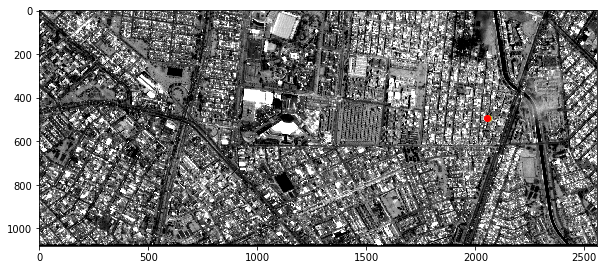

 ----> Real 2D loc in im 4  (sol) =  [2166.16308594  471.37789917]
 ----> Proj 2D loc in im 4  before BA =  [2174.78765244  472.93993378]
              Reprojection error beofre BA: 10.186601111766606


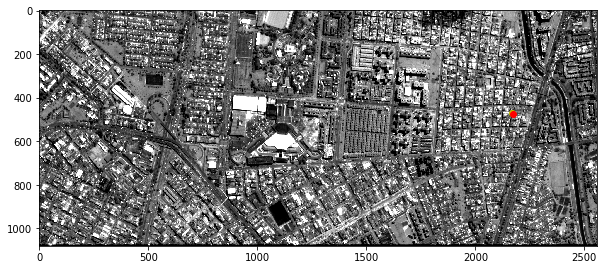

In [13]:
print('Initializing 3D points...')

pts_3d = ba_utils.initialize_3d_points(input_P, C, pairs_to_triangulate, cam_model)
print('...done!\n')

p_ind = np.random.choice(np.arange(0,C.shape[1]))
im_ind = [k for k, j in enumerate(range(n_img)) if not np.isnan(C[j*2,p_ind])]
    
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
#_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    
    #proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    #p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = input_P[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]  # col, row
    
    #if cont == 0:
        #print('3D location (initial)  :', pts_3d[p_ind,:].ravel())
        #print('3D location (after BA) :', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    #print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print('              Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    #print('              Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    
    fig = plt.figure(figsize=(10,20))
    
    plt.imshow(input_seq[i], cmap="gray")
    plt.plot(*p_2d_gt, "yo")
    plt.plot(*p_2d_proj, "ro")
    plt.show()
    
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    #f[cont].plot(*p_2d_proj_ba, "go")

Load feature tracks:

In [14]:
pickle_in = open(input_dir+'/features.pickle','rb')
C = pickle.load(pickle_in)
print('Correspondence matrix loaded!')

Correspondence matrix loaded!


Remove incomplete tracks if wanted:

In [15]:
# invert coords of the tracks (necessary when dealing with the preliminary camera model of skysat)
#C2 = np.zeros(C.shape)
#C2[::2,:] = C[1::2,:]
#C2[1::2,:] = C[::2, :]
#C = C2.copy()

# select a random subset of 1000 obs
#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (1000,), replace=False)
#C = C[:,idx_to_preserve]

#C = C[:, ~(np.sum((C!=C).astype(int), 0)).astype(bool)]

#print('Only complete feature tracks were preserved: {} in total'. format(C.shape[1]))

### Define Bundle Adjustment parameters

In [42]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

print('Defining BA input parameters...')
n_new, n_adj = int(C.shape[0]/2), 0
params_opt, cam_params, pts_3d, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, n_adj, n_new, pairs_to_triangulate)
print('...done!\n')

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{}\n'.format(pts_3d.shape, cam_params.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

Defining BA input parameters...
9 cameras in total, 0 fixed and 9 to be adjusted
3 parameters per camera and 1676 3d points to be optimized
...done!

pts_2d.shape:(4153, 2)  pts_ind.shape:(4153,)  cam_ind.shape:(4153,)
pts_3d.shape:(1676, 3)  cam_params.shape:(9, 11)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Run Bundle Adjustment (soft L1 loss)

Shape of matrix A: 8306x5055
`ftol` termination condition is satisfied.
Function evaluations 101, initial cost 2.9264e+04, final cost 1.8034e+02, first-order optimality 6.73e+04.
Optimization took 4 seconds

Error before BA (mean / median): 14.99 / 14.83
Error after  BA (mean / median): 0.30 / 0.24


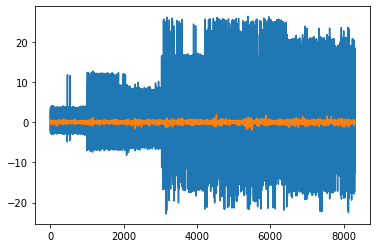

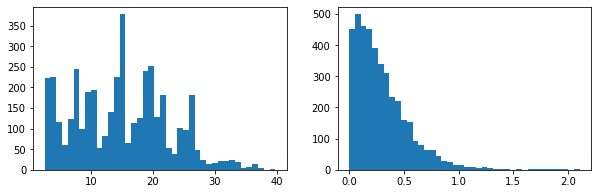

In [43]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
f0 = ba_utils.fun(params_opt, cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, params_opt, jac_sparsity=A, verbose=1, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds\n".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, cam_params, pts_3d)

# check BA error performance
ba_e = ba_utils.check_ba_error(f0, res.fun, pts_2d_w)

### Remove outliers according to reprojection error

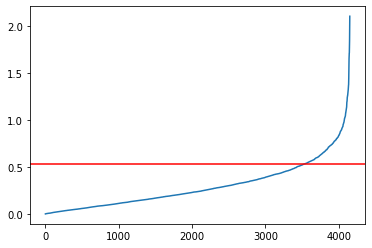

Deleted 1 observations (0.02%) and 0 tracks (0.00%)

Correspondence matrix saved!
Defining BA input parameters...
9 cameras in total, 0 fixed and 9 to be adjusted
3 parameters per camera and 1676 3d points to be optimized
...done!



In [44]:
elbow_value = ba_utils.get_elbow_value(ba_e, 95)
fig = plt.figure()
plt.plot(np.sort(ba_e))
plt.axhline(y=elbow_value, color='r', linestyle='-')
plt.show()
newC = ba_utils.remove_outlier_obs(ba_e, pts_ind, cam_ind, C, pairs_to_triangulate, thr=max(elbow_value,2.0))

pickle_out = open(input_dir+'/Cmatrix2.pickle','wb')
pickle.dump(newC, pickle_out)
pickle_out.close()
print('Correspondence matrix saved!')

print('Defining BA input parameters...')
params_opt, cam_params, pts_3d, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(input_P, newC, cam_model, n_adj, n_new, pairs_to_triangulate)
print('...done!\n')

### Run Bundle Adjustment L2 loss

Shape of matrix A: 8304x5055
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 4.1060e+05, final cost 2.1828e+02, first-order optimality 7.07e+03.
Optimization took 0 seconds

Error before BA (mean / median): 14.98 / 14.83
Error after  BA (mean / median): 0.31 / 0.25


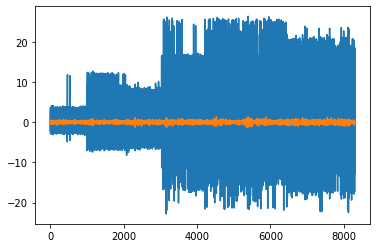

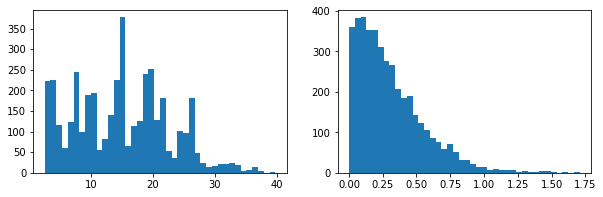

In [45]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters

f0 = ba_utils.fun(params_opt, cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, params_opt, jac_sparsity=A, verbose=1, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, #loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds\n".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, cam_params, pts_3d)

# check BA error performance
ba_e = ba_utils.check_ba_error(f0, res.fun, pts_2d_w)

### Visualize a feature track before and after Bundle Adjustment

Verify that the projections after Bundle Adjustment are closer to the observations of the feature track.

 ----> Real 2D loc in im 1  (sol) =  [361.77996826 270.49005127]
 ----> Proj 2D loc in im 1  before BA =  [354.67812553 269.01567529]
 ----> Proj 2D loc in im 1  after  BA =  [361.17227237 270.36384468]
              Reprojection error beofre BA: 8.576218707663713
              Reprojection error after  BA: 0.7339024813038577
 ----> Real 2D loc in im 4  (sol) =  [230.307724   322.40884399]
 ----> Proj 2D loc in im 4  before BA =  [239.771257   324.12442477]
 ----> Proj 2D loc in im 4  after  BA =  [230.84811075 322.50678949]
              Reprojection error beofre BA: 11.179113780678563
              Reprojection error after  BA: 0.6383322547405612

ECEF coordinates of the 3D point: [ 1737893.84624188 -6118081.68875399   510612.10355459]
lat, lon: [4.621, -74.142], alt: 2590.210


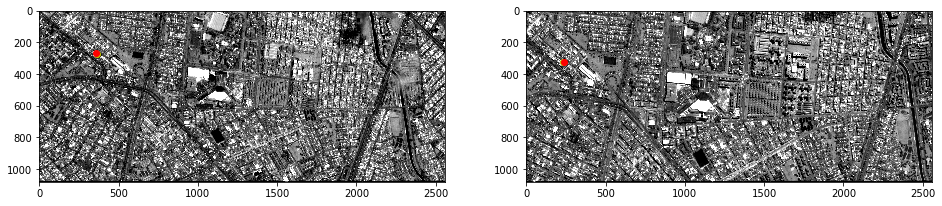

In [46]:
n_pts = newC.shape[1]
#p_ind = pts_ind[np.argmax(init_e)]
#p_ind = pts_ind[np.argmax(ba_e)] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(newC[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = newC[(i*2):(i*2+2),p_ind]
    
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    #if cont == 0:
        #print('3D location (initial)  :', pts_3d[p_ind,:].ravel())
        #print('3D location (after BA) :', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print('              Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    print('              Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    
    f[cont].imshow(mycrops[i]['crop'], cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    #f[cont].plot(*p_2d_proj_ba, "go")
    
print('\nECEF coordinates of the 3D point:', pts_3d_ba[p_ind])

lat, lon, h = ba_utils.ecef_to_latlon_custom(x=pts_3d_ba[p_ind,0], y=pts_3d_ba[p_ind,1], z=pts_3d_ba[p_ind,2])
print('lat, lon: [{:.3f}, {:.3f}], alt: {:.3f}'.format(lat, lon, h))

### Do the 3D points fall in the correct place?

Verify that the projection of the bounding box containing the point cloud of the scene falls in the correct area of the Earth.

In [47]:
lat, lon, alt = ba_utils.ecef_to_latlon_custom(pts_3d_ba[:,0], pts_3d_ba[:,1], pts_3d_ba[:,2])

mymap = vistools.clickablemap(zoom=12)
## set the coordinates of the area of interest as a GeoJSON polygon
aoi = {'coordinates': [[[min(lon), min(lat)], [min(lon), max(lat)], 
                        [max(lon), max(lat)], [max(lon), min(lat)],
                        [min(lon), min(lat)]]], 'type': 'Polygon'}
# set the center of the aoi
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()
# display a polygon covering the aoi and center the map
mymap.add_GeoJSON(aoi) 
mymap.center = aoi['center'][::-1]
mymap.zoom = 15         
display(mymap)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

Mean abs reproj error before BA: 7.1477
Mean abs reproj error after  BA: 0.2893


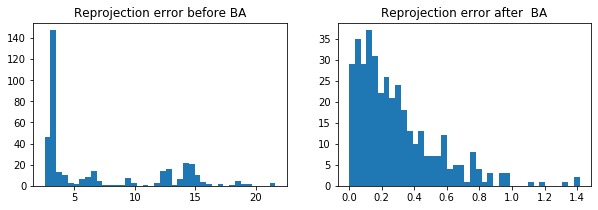

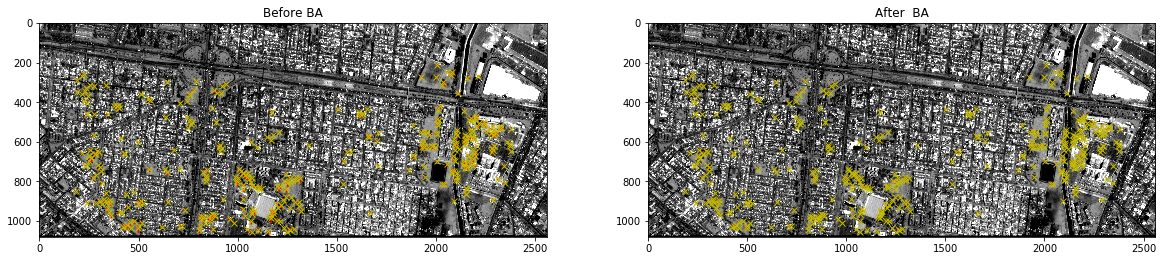

In [49]:
# set the index of the image to analyse
im_idx = 0

# pick all points visible in the selected image

pts2d = newC[(im_idx*2):(im_idx*2+2),~np.isnan(newC[im_idx*2,:])].T
pts3d_before = pts_3d[~np.isnan(newC[im_idx*2,:]),:]
pts3d_after = pts_3d_ba[~np.isnan(newC[im_idx*2,:]),:]

ba_utils.display_ba_error_particular_view(P_crop[im_idx], P_crop_ba[im_idx], pts3d_before, pts3d_after, pts2d, mycrops[im_idx]['crop'])

Simple visualization. Green crosses represent the detected feature tracks, and red vectors are the distance to the reprojected point locations. 

### Check the distance between the projection rays of two cameras

This gives an idea of the error in the traingulation of points before and after Bundle Adjustment.

Checking the distance between projection rays...
...done!



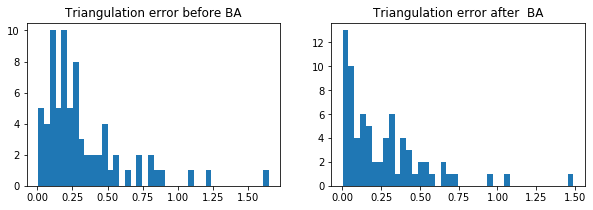

In [50]:
from PIL import Image

print('Checking the distance between projection rays...')

im1, im2 = 0,1

# get SIFT keypoints visible in both images
visible_idx = np.logical_and(~np.isnan(newC[im1*2,:]), ~np.isnan(newC[im2*2,:])) 
pts1, pts2 = newC[(im1*2):(im1*2+2), visible_idx], newC[(im2*2):(im2*2+2), visible_idx]
tr_err, tr_err_ba = [],[]
pts_3d_sift, pts_3d_sift_ba = np.zeros((pts1.shape[1], 3)), np.zeros((pts1.shape[1], 3))

triangulate_err_hist = True 
triangulate_err_dsm  = False

# triangulate and compute triangulation error (i.e. distance between projection rays)
for n in range(pts1.shape[1]):
    pt1, pt2 = pts1[:,n].ravel(), pts2[:,n].ravel()
    # before bundle adjustment
    pts_3d_sift[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop[im1], P_crop[im2])
    tr_err.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop[im1], P_crop[im2]))
    # after bundle adjustment
    pts_3d_sift_ba[n,:] = ba_utils.linear_triangulation_single_pt(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2])
    tr_err_ba.append(ba_utils.dist_between_proj_rays(pt1, pt2, P_crop_ba[im1], P_crop_ba[im2]))

if triangulate_err_hist:
    fig = plt.figure(figsize=(10,3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.title.set_text('Triangulation error before BA')
    ax2.title.set_text('Triangulation error after  BA')
    ax1.hist(tr_err, bins=40); 
    ax2.hist(tr_err_ba, bins=40);
    
# project dsm of the cloud but instead of projecting the height, project the triangulation error
if triangulate_err_dsm:
    # before bundle adjustment
    x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}.tif'.format(im1,im2))
    # after bundle adjustment
    x , y, z = pts_3d_sift_ba[:,0], pts_3d_sift_ba[:,1], pts_3d_sift_ba[:,2]
    lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
    east, north = utils.utm_from_lonlat(lon, lat)
    xyz = np.vstack((east, north, tr_err_ba)).T
    _, dem_nan, _ = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/triangulate_{}_{}_ba.tif'.format(im1,im2))
    
print('...done!\n')

### Save point clouds of SIFT keypoints before and after Bundle Adjustment 

In [ ]:
print('Writing point clouds of SIFT keypoints...')

if not os.path.isdir(input_dir+'/sift_clouds_before'):
    os.mkdir(input_dir+'/sift_clouds_before')
if not os.path.isdir(input_dir+'/sift_clouds_after'):
    os.mkdir(input_dir+'/sift_clouds_after')

'''
# pairs with extremly short baselines are not well posed for depth from stereo so we filter them
pairs_to_match = []
for i in range(n_cam):
    for j in range(i+1,n_cam):
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop[i])
        _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop[j])
        if np.linalg.norm(optical_center2 - optical_center1) > 150000 :
            pairs_to_match.append([i,j])  
'''    

max_east, min_east = - np.inf, np.inf
max_north, min_north = - np.inf, np.inf

for [im1,im2] in pairs_to_match:
        
    # get SIFT keypoints visible in both images
    visible_idx = np.logical_and(~np.isnan(newC[im1*2,:]), ~np.isnan(newC[im2*2,:])) 
    pts1, pts2 = newC[(im1*2):(im1*2+2), visible_idx], newC[(im2*2):(im2*2+2), visible_idx]

    if len(pts1[0]) > 10:
        
        print(im1, im2)
        
        # triangulation of SIFT keypoints before bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop[im1], P_crop[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_before/{:02}_{:02}.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))

        # triangulation of SIFT keypoints after bundle adjustment
        pts_3d_sift = ba_utils.triangulate_list_of_matches(pts1, pts2, P_crop_ba[im1], P_crop_ba[im2])
        x , y, z = pts_3d_sift[:,0], pts_3d_sift[:,1], pts_3d_sift[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        fn = input_dir+'/sift_clouds_after/{:02}_{:02}_ba.ply'.format(im1, im2)
        ba_utils.write_point_cloud_ply(fn, xyz, color=np.random.choice(range(256), size=3))
        
        if min(east) < min_east:
            min_east = min(east)
        if max(east) > max_east:
            max_east = max(east)
        if min(north) < min_north:
            min_north = min(north)
        if max(north) > max_north:
            max_north = max(north)

print('min_east:', min_east)
print('max_east:', max_east)
print('min_north:', min_north)
print('max_north:', max_north)

print('...done!\n')

### Save the corrected matrices

In [57]:
import json

if not os.path.isdir(input_dir+'/P_adj'):
    os.mkdir(input_dir+'/P_adj')
    
for im_idx in range(n_cam):
    P_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_pinhole_adj.json'
    
    to_write = {
        # 'P_camera'
        # 'P_extrinsic'
        # 'P_intrinsic'
        "P_projective": [P_crop_ba[im_idx][0,:].tolist(), 
                         P_crop_ba[im_idx][1,:].tolist(),
                         P_crop_ba[im_idx][2,:].tolist()],
        # 'exterior_orientation'
        "height": mycrops[im_idx]['crop'].shape[0],
        "width": mycrops[im_idx]['crop'].shape[1]        
    }
    
    with open(input_dir+'/P_adj/'+P_calib_fn, 'w') as json_file:
        json.dump(to_write, json_file, indent=4)

### Recover the corrected RPCs from the corrected projection matrices

In [13]:
#fit rpc

import rpc_fit
import copy

if not os.path.isdir(input_dir+'/RPC_adj'):
    os.mkdir(input_dir+'/RPC_adj')

# rpc fitting starts here
myrpcs_calib = []
verbose = True
for im_idx in range(n_cam):

    rpc_init = copy.copy(myrpcs2[im_idx])
    
    # calibrate and get error
    input_P, input_im, input_ecef = P_crop_ba[im_idx], mycrops[im_idx]['crop'], pts_3d_ba
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)
    print('image {}, RMSE calibrated RPC = {}'.format(im_idx, err_calib))
    
    rpc_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_RPC_adj.txt'
    rpc_calib.write_to_file(input_dir+'/RPC_adj/'+rpc_calib_fn)
    
    myrpcs_calib.append(rpc_calib)
    
    # check the histogram of errors if the RMSE error is above subpixel
    if err_calib > 1.0 and verbose:
        col_pred, row_pred = rpc_calib.projection(lon, lat, alt)
        err = np.sum(abs(np.hstack([col_pred.reshape(-1, 1), row_pred.reshape(-1, 1)]) - target), axis=1)
        plt.figure()
        plt.hist(err, bins=30);
        plt.show()

image 0, RMSE calibrated RPC = 3.980229574465902e-05
image 1, RMSE calibrated RPC = 2.7159961193324734e-05
image 2, RMSE calibrated RPC = 0.00016648050273774693
image 3, RMSE calibrated RPC = 0.00014458728243170474
image 4, RMSE calibrated RPC = 2.3740506107445886e-05
image 5, RMSE calibrated RPC = 0.00013365982256063706
image 6, RMSE calibrated RPC = 5.627893698635081e-05
image 7, RMSE calibrated RPC = 2.334460659541979e-05
image 8, RMSE calibrated RPC = 8.268399066834438e-05


Verify that the reprojection of 3d points with the RPC is closer than 0.0001 to the reprojection given by the corrected projection matrix.

In [14]:
# check that the calibrated RPCs are OK

for im_idx in range(int(newC.shape[0]/2)):
    for p_idx in range(newC.shape[1]):
        if not np.isnan(newC[2*im_idx,p_idx]):
            p_2d_gt = newC[(im_idx*2):(im_idx*2+2),p_idx]
            current_p = pts_3d_ba[p_idx,:]
            lat, lon, alt = ba_utils.ecef_to_latlon_custom(current_p[0], current_p[1], current_p[2])
            proj = P_crop[im_idx] @ np.expand_dims(np.hstack((current_p, np.ones(1))), axis=1)
            p_2d_proj = (proj[0:2,:] / proj[-1,-1]).ravel()
            col, row = myrpcs2[im_idx].projection(lon, lat, alt)
            p_2d_proj_rpc = np.hstack([col - mycrops[im_idx]['x0'], row - mycrops[im_idx]['y0']]).ravel()
            proj = P_crop_ba[im_idx] @ np.expand_dims(np.hstack((current_p, np.ones(1))), axis=1)
            p_2d_proj_ba = (proj[0:2,:] / proj[-1,-1]).ravel()
            col, row = myrpcs_calib[im_idx].projection(lon, lat, alt)
            p_2d_proj_rpc_ba = np.hstack([col, row])

            reprojection_error_P = np.sum(abs(p_2d_proj_ba - p_2d_gt))
            reprojection_error_RPC = np.sum(abs(p_2d_proj_rpc_ba - p_2d_gt))

            if abs(reprojection_error_RPC - reprojection_error_P) > 0.001:
                print('cam {}, point {}'.format(im_idx, p_idx))
                print('GT            : {:.4f} , {:.4f}'.format(p_2d_gt[0], p_2d_gt[1]))
                print('RPC proj      : {:.4f} , {:.4f}'.format(p_2d_proj_rpc[0], p_2d_proj_rpc[1]))
                print('P proj        : {:.4f} , {:.4f}'.format(p_2d_proj[0], p_2d_proj[1]))
                print('P proj   (BA) : {:.4f} , {:.4f}'.format(p_2d_proj_ba[0], p_2d_proj_ba[1]))
                print('RPC proj (BA) : {:.4f} , {:.4f}'.format(p_2d_proj_rpc_ba[0], p_2d_proj_rpc_ba[1]))

    print('Finished checking image {}'.format(im_idx))

Finished checking image 0
Finished checking image 1
Finished checking image 2
Finished checking image 3
Finished checking image 4
Finished checking image 5
Finished checking image 6
Finished checking image 7
Finished checking image 8


### Check baseline distances

In [ ]:
baseline_pairs, all_pairs_list = [], []
for i in range(n_img):
    for j in range(i+1,n_img):

        # check if the baseline between both cameras is large enough
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_crop_ba[i])
        _, _, _, optical_center2 = ba_utils.decompose_projection_matrix(P_crop_ba[j])
        baseline_pairs.append(np.linalg.norm(optical_center2 - optical_center1))
        all_pairs_list.append([i,j])

plt.plot(baseline_pairs)
plt.show()

In [ ]:
# check connectivity graph

#ba_utils.plot_connectivity_graph(newC, 10, save_pgf=False)

### Compare reprojection error using the L1A projection matrices or rpcs

In [15]:
import rpc_fit
import copy

original_rpcs = [s2p.rpc_utils.rpc_from_geotiff(x) for x in myimages]

for im_idx in range(n_cam):

    rpc_init = copy.copy(original_rpcs[im_idx])

    h, w = mycrops[im_idx]['crop'].shape

    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            input_P = np.array(json.load(f)['P_projective'])

    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)


    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 0, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts_P, samples = p[idx_to_preserve], samples[idx_to_preserve]

    lat, lon, alt = ba_utils.ecef_to_latlon_custom(samples[:, 0], samples[:, 1], samples[:, 2])

    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)

    rows, cols = original_rpcs[im_idx].projection(lon, lat, alt) # ROWS Y COL ESTAN AL REVES ?
    proj_pts_RPC = np.vstack((rows, cols)).T
    
    print('im {} max diff {}'.format(im_idx, max(np.linalg.norm(proj_pts_P-proj_pts_RPC,axis=1))))

im 0 max diff 1.1805789242082083
im 1 max diff 1.1738532795489727
im 2 max diff 1.3840531351700023
im 3 max diff 1.6089497427823791
im 4 max diff 1.4171598111702823
im 5 max diff 1.6695201457271214
im 6 max diff 1.3392344720556661
im 7 max diff 1.4078326557017402
im 8 max diff 1.17794829830861


In [ ]:
plt.plot(np.linalg.norm(proj_pts_P-proj_pts_RPC, axis=1))

### Plot optical centers in 3D

In [ ]:
read_from_matrices = False
read_from_exterior_orientation = False

P_matrices = []
ocenters = []

if read_from_matrices:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            P_matrices.append(np.array(json.load(f)['P_projective']))
            _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_matrices[i])
            ocenters.append(optical_center1)    
elif read_from_exterior_orientation:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            tmp = json.load(f)['exterior_orientation']
            x_ecef, y_ecef, z_ecef = tmp['x_ecef_meters'], tmp['y_ecef_meters'], tmp['z_ecef_meters']
            ocenters.append(np.array([x_ecef, y_ecef, z_ecef]))
else: # read from rpcs approximation
    cam_model = 'Perspective'
    P_matrices = []
    for rpc2, crop, iter_cont in zip(myrpcs2, mycrops, np.arange(len(mycrops))):
        x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
        P_img = s2p.rpc_utils.approx_rpc_as_proj_matrix(rpc2, [x,x+w,10], [y,y+h,10], \
                                                    [rpc2.alt_offset - 100, rpc2.alt_offset + 100, 10])
        _, _, _, optical_center1 = ba_utils.decompose_projection_matrix(P_img/P_img[2,3])
        ocenters.append(optical_center1)
    
ocenters = np.array(ocenters)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.plot(ocenters[:,0], ocenters[:,1], ocenters[:,2], 'o')